In [1]:
from data import ChallengeDataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

c:\FAU_Programming\Deep_Learning\exercise4\src_to_implement\data.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('data.csv', sep=';')
df

,filename,crack,inactive
0,images/cell2044.png,1,0
1,images/cell0123.png,0,0
2,images/cell2241.png,0,0
3,images/cell2426.png,0,0
4,images/cell1552.png,0,0
...,...,...,...
1995,images/cell1615.png,1,1
1996,images/cell0444.png,1,1
1997,images/cell1414.png,0,0
1998,images/cell1300.png,0,0


In [3]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
# balance training dataset
len(train)

1600

In [5]:
train["class_combo"] = train["class_combo"] = train.apply(lambda row: f"{row['crack']}_{row['inactive']}", axis=1)

c:\Users\graun\miniconda3\envs\detect-defect-solar-cells\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
train.head()

,filename,crack,inactive,class_combo
968,images/cell2358.png,0,0,0_0
240,images/cell0632.png,0,0,0_0
819,images/cell2445.png,0,0,0_0
692,images/cell2159.png,0,0,0_0
420,images/cell0074.png,0,0,0_0


In [7]:
num00 = len(train[train["class_combo"] == "0_0"])
num01 = len(train[train["class_combo"] == "0_1"])
num10 = len(train[train["class_combo"] == "1_0"])
num11 = len(train[train["class_combo"] == "1_1"])

label_counts = [num00, num01, num10, num11]
label_counts


[1236, 10, 269, 85]

In [8]:
# calc balancing factors
balancing_fac = []
for count in label_counts:
    balancing_fac.append((500-count)) #500 samples per clas
balancing_fac

[-736, 490, 231, 415]

In [9]:
# downsample
balanced_00 = train[train["class_combo"] == "0_0"].sample(n = 500, replace=True, random_state=42)
balanced_00

,filename,crack,inactive,class_combo
592,images/cell1445.png,0,0,0_0
1002,images/cell1186.png,0,0,0_0
1152,images/cell1620.png,0,0,0_0
1484,images/cell0300.png,0,0,0_0
1410,images/cell0205.png,0,0,0_0
...,...,...,...,...
1411,images/cell0085.png,0,0,0_0
899,images/cell1802.png,0,0,0_0
627,images/cell1704.png,0,0,0_0
1572,images/cell1317.png,0,0,0_0


In [10]:
from torch.utils.data import Dataset
import torch
from pathlib import Path
from skimage.io import imread
from skimage.color import gray2rgb
import numpy as np
import torchvision as tv
import torchvision.transforms as T
from torchvision.utils import save_image
from pathlib import Path

In [11]:
class DataAugmenter:
    def __init__(self, output_dir="augmented", num_augs=1):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        self.num_augs = num_augs

        self.aug_tfs = [
            T.ToPILImage(),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
            T.ColorJitter(brightness=0.4, contrast=0.2),
        ]
        self.transform = T.Compose(self.aug_tfs)

    def augment(self, df: pd.DataFrame) -> pd.DataFrame:
        new_rows = []

        for idx, row in df.iterrows():
            filename = Path(row["filename"])
            img = imread(filename)

            # Convert to RGB if needed
            if img.ndim == 2 or img.shape[-1] == 1:
                img = gray2rgb(img)
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8) if img.max() <= 1 else img.astype(np.uint8)

            for i in range(self.num_augs):
                img_aug = self.transform(img)

                # Create new filename
                stem = filename.stem
                suffix = filename.suffix if filename.suffix else ".png"
                new_name = f"{stem}_aug{i+1}{suffix}"
                save_path = self.output_dir / new_name

                # Save image
                img_aug.save(save_path)

                # Append new row
                new_rows.append({
                    "filename": str(save_path),
                    "crack": row["crack"],
                    "inactive": row["inactive"],
                    "class_combo": row["class_combo"]
                })

        return pd.DataFrame(new_rows)


In [12]:
balanced_01 = train[train["class_combo"] == "0_1"]

augmenter = DataAugmenter(output_dir="augmented", num_augs=49)
new_rows_01 = augmenter.augment(balanced_01)
balanced_01 = pd.concat([balanced_01, new_rows_01])
balanced_01

,filename,crack,inactive,class_combo
596,images/cell1976.png,0,1,0_1
1943,images/cell0708.png,0,1,0_1
1992,images/cell0702.png,0,1,0_1
545,images/cell0203.png,0,1,0_1
1632,images/cell1616.png,0,1,0_1
...,...,...,...,...
485,augmented\cell0437_aug45.png,0,1,0_1
486,augmented\cell0437_aug46.png,0,1,0_1
487,augmented\cell0437_aug47.png,0,1,0_1
488,augmented\cell0437_aug48.png,0,1,0_1


In [13]:
balanced_10  = train[train["class_combo"] == "1_0"]

augmenter = DataAugmenter(output_dir="augmented", num_augs=2)
new_rows_10 = augmenter.augment(balanced_10)
balanced_10 = pd.concat([balanced_10, new_rows_10])
balanced_10 = balanced_10.sample(n = 500, replace=True, random_state=42)
balanced_10

,filename,crack,inactive,class_combo
1804,images/cell0693.png,1,0,1_0
166,augmented\cell1409_aug1.png,1,0,1_0
1,augmented\cell1059_aug2.png,1,0,1_0
666,images/cell0486.png,1,0,1_0
215,images/cell2517.png,1,0,1_0
...,...,...,...,...
532,augmented\cell0305_aug1.png,1,0,1_0
224,images/cell0876.png,1,0,1_0
368,augmented\cell0675_aug1.png,1,0,1_0
448,images/cell0001.png,1,0,1_0


In [14]:
balanced_11  = train[train["class_combo"] == "1_1"]

augmenter = DataAugmenter(output_dir="augmented", num_augs=5)
new_rows_11 = augmenter.augment(balanced_11)
balanced_11 = pd.concat([balanced_11, new_rows_11])
balanced_11 = balanced_11.sample(n = 500, replace=True, random_state=42)
balanced_11

,filename,crack,inactive,class_combo
17,augmented\cell0499_aug3.png,1,1,1_1
350,augmented\cell0451_aug1.png,1,1,1_1
263,augmented\cell0889_aug4.png,1,1,1_1
185,augmented\cell0523_aug1.png,1,1,1_1
21,augmented\cell1674_aug2.png,1,1,1_1
...,...,...,...,...
105,augmented\cell1643_aug1.png,1,1,1_1
167,augmented\cell0469_aug3.png,1,1,1_1
383,augmented\cell1668_aug4.png,1,1,1_1
330,augmented\cell0505_aug1.png,1,1,1_1


In [15]:
print(len(balanced_00))
print(len(balanced_01))
print(len(balanced_10))
print(len(balanced_11))

500
500
500
500


In [16]:
balanced_df = pd.concat([balanced_00, balanced_01, balanced_10, balanced_11], ignore_index=True)

In [17]:
balanced_df

,filename,crack,inactive,class_combo
0,images/cell1445.png,0,0,0_0
1,images/cell1186.png,0,0,0_0
2,images/cell1620.png,0,0,0_0
3,images/cell0300.png,0,0,0_0
4,images/cell0205.png,0,0,0_0
...,...,...,...,...
1995,augmented\cell1643_aug1.png,1,1,1_1
1996,augmented\cell0469_aug3.png,1,1,1_1
1997,augmented\cell1668_aug4.png,1,1,1_1
1998,augmented\cell0505_aug1.png,1,1,1_1


In [18]:
balanced_df.to_csv("data_balanced_aug_train.csv")
val.to_csv("data_balanced_aug_val.csv")

In [19]:
######## inactive boost #############

import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import random

class InactiveContrastBoost:
    """
    Nur auf Bilder mit inactive=1 anwenden. 
    Verstärkt Kontrast in sehr dunklen Bereichen.
    """
    def __init__(self, active_label):
        self.active_label = active_label  # erwartet: 0 oder 1

    def __call__(self, img):
        if self.active_label == 1:
            img = self.boost_dark_regions(img)
        return img

    def boost_dark_regions(self, img):
        np_img = np.array(img).astype(np.float32)

        # Maskiere sehr dunkle Bereiche (< 50) und verdunkle sie weiter
        dark_mask = np_img < 50
        np_img[dark_mask] = np_img[dark_mask] * 0.5  # noch dunkler

        # Clipping und Normalisierung
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)
        return Image.fromarray(np_img)

# Beispiel: Transform-Kette
def get_transform(is_inactive):
    return transforms.Compose([
        transforms.Resize((128, 128)),
        InactiveContrastBoost(active_label=is_inactive),
        transforms.ToTensor(),
    ])


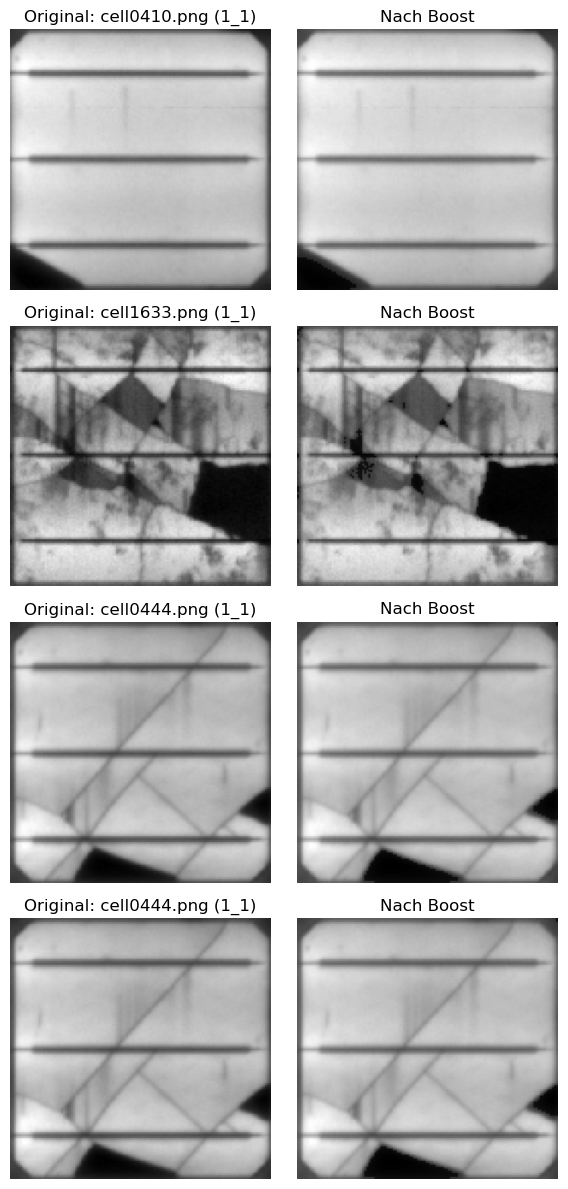

In [31]:
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ✅ Deine Boosting-Klasse
class InactiveContrastBoost:
    def __init__(self, active_label):
        self.active_label = active_label

    def __call__(self, img):
        if self.active_label == 1:
            return self.boost_dark_regions(img)
        return img

    def boost_dark_regions(self, img):
        np_img = np.array(img).astype(np.float32)
        dark_mask = np_img < 50
        np_img[dark_mask] *= 0.5
        np_img = np.clip(np_img, 0, 255).astype(np.uint8)
        return Image.fromarray(np_img)

# 📂 Bildordner definieren
image_dir = Path("images")

# 🔧 Stelle sicher, dass 'file_only' vorhanden ist
if "file_only" not in balanced_df.columns:
    balanced_df["file_only"] = balanced_df["filename"].apply(lambda x: Path(x).name)

# 🎯 Filter auf inactive = 1
to_boost_df = balanced_df[balanced_df["class_combo"].isin(["0_1", "1_1"])].copy()

# 🧹 Nur Bilder nehmen, die wirklich existieren
to_boost_df["full_path"] = to_boost_df["file_only"].apply(lambda f: image_dir / f)
to_boost_df = to_boost_df[to_boost_df["full_path"].apply(lambda p: p.exists())]

# 🔁 Nimm z. B. 4 zufällige Beispielbilder
sample_df = to_boost_df.sample(4, random_state=22)

# 📊 Plot: Original vs. Nach Boost
fig, axs = plt.subplots(len(sample_df), 2, figsize=(6, 3 * len(sample_df)))

for i, (_, row) in enumerate(sample_df.iterrows()):
    original = Image.open(row["full_path"]).convert("L").resize((128, 128))
    boosted = InactiveContrastBoost(active_label=1)(original.copy())

    axs[i, 0].imshow(original, cmap='gray')
    axs[i, 0].set_title(f"Original: {row['file_only']} ({row['class_combo']})")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(boosted, cmap='gray')
    axs[i, 1].set_title("Nach Boost")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


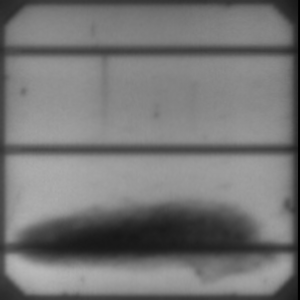

In [26]:
img_path1 = "images"
img_name = "cell0005.png"
img_path = Path(img_path1) / Path(img_name)
Image.open(img_path)

In [28]:
balanced_df["file_only"]

0            cell1445.png
1            cell1186.png
2            cell1620.png
3            cell0300.png
4            cell0205.png
              ...        
1995    cell1643_aug1.png
1996    cell0469_aug3.png
1997    cell1668_aug4.png
1998    cell0505_aug1.png
1999    cell1631_aug1.png
Name: file_only, Length: 2000, dtype: object